# 模型集成 Model Ensembles

Triton 通过模型集成让多个模型形成流水线，一次性完成预处理、推理和后处理等全部工序。

参考资料：

- [Model_Ensembles](https://github.com/triton-inference-server/tutorials/tree/main/Conceptual_Guide/Part_5-Model_Ensembles)

In [1]:
# !pip install -U onnx onnxruntime onnxruntime-tools onnxruntime-gpu

In [2]:
import os

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [3]:
import base64
import torch
import requests
import numpy as np
import onnxruntime as ort

import utils

from io import BytesIO
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

In [5]:
MODEL_PATH = 'workspace'
DATA_PATH = 'data'
TEXT_CUSTOM_PATH = 'custom_clip_text.onnx'
IMAGE_CUSTOM_PATH = 'custom_clip_image.onnx'

model_name = 'openai/clip-vit-base-patch32'
model_path = utils.gen_abspath(directory='./', rel_path=MODEL_PATH)

cat_img_path = utils.gen_abspath(directory=DATA_PATH, rel_path='cat.JPG')
emoji_img_path = utils.gen_abspath(directory=DATA_PATH, rel_path='emoji_2.JPG')

text_custom_onnx_path = utils.gen_abspath(directory=MODEL_PATH, rel_path=TEXT_CUSTOM_PATH)
img_custom_onnx_path = utils.gen_abspath(directory=MODEL_PATH, rel_path=IMAGE_CUSTOM_PATH)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


Pillow 图像和 Base64 互转。

In [6]:
def image_to_base64(image, format=None):
    if format is None:
        format = image.format

    buffered = BytesIO()
    image.save(buffered, format=format)  # format 图像格式，例如 "JPEG" 或 "PNG"
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_base64

def img_file_to_base64(image_path):
    try:
        with open(image_path, "rb") as f:
            return base64.b64encode(f.read()).decode("ascii")
    except FileNotFoundError:
        return None

def base64_to_image(base64_string):
    return Image.open(BytesIO(base64.b64decode(base64_string)))

In [7]:
base64_string = image_to_base64(Image.open(emoji_img_path), format='JPEG')
len(base64_string)

47252

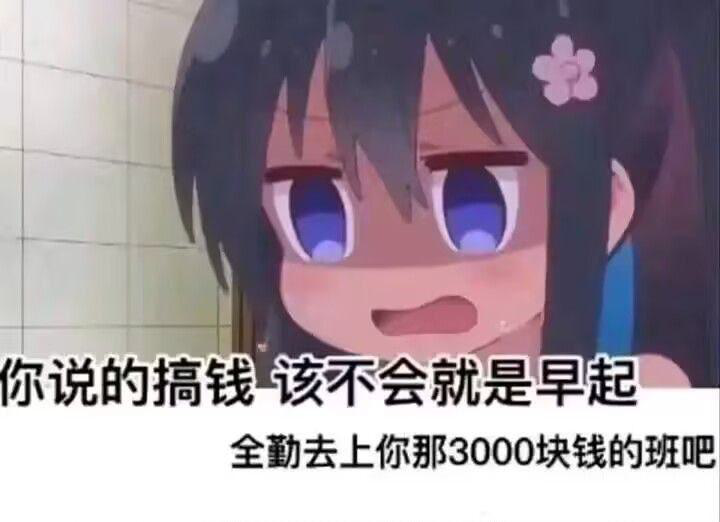

In [8]:
emoji_img = base64_to_image(base64_string)
emoji_img

## 1. 模型拆解

先把模型主体、预处理、后处理等各部分代码拆开。

注意模型主体的输入必须是张量。如果不是张量，需要在 forward 函数之外做预处理。

In [9]:
class TextEmbedding(torch.nn.Module):
    def __init__(self, model_name, model_path, device):
        super().__init__()
        self.processor = CLIPProcessor.from_pretrained(model_name, cache_dir=model_path)
        self.model = CLIPModel.from_pretrained(model_name, cache_dir=model_path).to(device)
        self.device = device

    def preprocess(self, texts):
        inputs = self.processor(text=texts,
                                return_tensors="pt",
                                padding=True,
                                truncation=True).to(self.device)
        return inputs['input_ids'], inputs['attention_mask']

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embeddings = self.model.get_text_features(input_ids=input_ids,
                                                      attention_mask=attention_mask)
        text_embeddings = embeddings / embeddings.norm(p=2, dim=-1, keepdim=True)
        return text_embeddings

class ImageEmbedding(torch.nn.Module):
    def __init__(self, model_name, model_path, device):
        super().__init__()
        self.processor = CLIPProcessor.from_pretrained(model_name, cache_dir=model_path)
        self.model = CLIPModel.from_pretrained(model_name, cache_dir=model_path).to(device)
        self.device = device

    @staticmethod
    def base64_to_image(base64_string):
        return Image.open(BytesIO(base64.b64decode(base64_string)))

    def preprocess(self, base64_images):
        images = [self.base64_to_image(im) for im in base64_images]
        inputs = self.processor(images=images, return_tensors="pt").to(self.device)
        return inputs['pixel_values']

    def forward(self, pixel_values):
        with torch.no_grad():
            embeddings = self.model.get_image_features(pixel_values=pixel_values)
        image_embeddings = embeddings / embeddings.norm(p=2, dim=-1, keepdim=True)
        return image_embeddings

In [11]:
# 文本模型实例
text_embd_model = TextEmbedding(model_name=model_name,
                                model_path=model_path,
                                device=device)

# 图像模型实例
image_embd_model = ImageEmbedding(model_name=model_name,
                                  model_path=model_path,
                                  device=device)

In [12]:
# 文本模型推理
example_texts = ["A photo of a cat!", "A picture of a dog"]
input_ids, attention_mask = text_embd_model.preprocess(example_texts)
text_embedding = text_embd_model(input_ids, attention_mask)
text_embedding.shape

torch.Size([2, 512])

In [13]:
# 图像模型推理
example_images = [
    image_to_base64(Image.open(cat_img_path)),
    image_to_base64(Image.open(emoji_img_path))
]
pixel_values = image_embd_model.preprocess(example_images)
image_embedding = image_embd_model(pixel_values)
pixel_values.shape, image_embedding.shape

(torch.Size([2, 3, 224, 224]), torch.Size([2, 512]))

## 2. 转换为 ONNX

将模型主体转换为 ONNX 格式。

In [14]:
# help(torch.onnx.export)

In [17]:
# 输入样例
text_example_inputs = (input_ids, attention_mask)

# 导出文本 Embedding 模型
torch.onnx.export(
    model=text_embd_model,  # 模型
    args=text_example_inputs,  # 模型输入样例
    f=text_custom_onnx_path,  # 输出文件名
    export_params=True,  # 导出模型参数
    opset_version=20,  # ONNX 操作集版本
    input_names=['input_ids', 'attention_mask'],  # 输入名
    output_names=['text_embeddings'],  # 输出名
    dynamic_axes={
        'input_ids': {0: "batch_size", 1: "sequence_length"},  # 第 0 维和第 1 维是动态的
        'attention_mask': {0: "batch_size", 1: "sequence_length"},
        'text_embeddings': {0: 'batch_size'}  # 第 0 维是动态的（batch_size）
    }
)

In [18]:
# 输入样例
img_example_inputs = (pixel_values, )

# 导出图像 Embedding 模型
torch.onnx.export(
    model=image_embd_model,  # 模型
    args=img_example_inputs,  # 模型输入样例
    f=img_custom_onnx_path,  # 输出文件名
    export_params=True,  # 导出模型参数
    opset_version=20,  # ONNX 操作集版本
    input_names=['pixel_values'],  # 输入名
    output_names=['image_embeddings'],  # 输出名
    dynamic_axes={
        'pixel_values': {0: 'batch_size'},  # 第0维是动态的（batch_size）
        'image_embeddings': {0: 'batch_size'}  # 第0维是动态的（batch_size）
    }
)

## 3. 验证 ONNX 模型

### 1）本地验证

加载 ONNX 文件并执行推理。

In [19]:
# 加载文本 ONNX
text_session = ort.InferenceSession(text_custom_onnx_path)

# 文本 Embedding 推理
input_ids, attention_mask = text_example_inputs
outputs = text_session.run(None, {
    "input_ids": np.array(input_ids.cpu()),
    "attention_mask": np.array(attention_mask.cpu())
})
outputs[0].shape

(2, 512)

In [20]:
# 加载图像 ONNX
img_session = ort.InferenceSession(img_custom_onnx_path)

# 图像 Embedding 推理
pixel_values = img_example_inputs[0]
outputs = img_session.run(None, {
    "pixel_values": np.array(pixel_values.cpu())
})
outputs[0].shape

(2, 512)

### 2）Triton 验证

部署到 Triton 后验证。

**文本 ONNX 推理客户端**

In [21]:
TRITON_URL = 'http://localhost:8000'

TEXT_ONNX_MODEL = 'clip_text_onnx'
IMG_ONNX_MODEL = 'clip_image_onnx'
TEXT_PREPROCESS_MODEL = 'clip_text_preprocess'
IMG_PREPROCESS_MODEL = 'clip_image_preprocess'
TEXT_ENSEMBLE_MODEL = 'clip_text_ensemble'
IMG_ENSEMBLE_MODEL = 'clip_image_ensemble'

In [22]:
# 文本推理客户端连通性检测
utils.check_model_health(model_name=TEXT_ONNX_MODEL)

Model 'clip_text_onnx' is ready.


In [23]:
# 构造请求体
inputs = {
    "inputs": [
        {
            "name": 'input_ids',
            "shape": list(input_ids.shape),
            "datatype": "INT64",
            "data": input_ids.flatten().tolist()
        },
        {
            "name": 'attention_mask',
            "shape": list(attention_mask.shape),
            "datatype": "INT64",
            "data": attention_mask.flatten().tolist()
        }
    ]
}

# 获取推理结果
r = utils.simple_client(inputs=inputs,
                        model_name=TEXT_ONNX_MODEL)
r.keys(), np.array(r['outputs'][0]['data']).shape

(dict_keys(['model_name', 'model_version', 'outputs']), (1024,))

**图像 ONNX 推理客户端**

In [24]:
# 图像推理客户端连通性检测
utils.check_model_health(model_name=IMG_ONNX_MODEL)

Model 'clip_image_onnx' is ready.


In [25]:
# 构造请求体
inputs = {
    "inputs": [
        {
            "name": 'pixel_values',
            "shape": list(pixel_values.shape),
            "datatype": "FP32",
            "data": pixel_values.flatten().tolist()
        }
    ]
}

# 获取推理结果
r = utils.simple_client(inputs=inputs,
                        model_name=IMG_ONNX_MODEL)
r.keys(), np.array(r['outputs'][0]['data']).shape

(dict_keys(['model_name', 'model_version', 'outputs']), (1024,))

## 4. Python Backend 模型

把文本和图像预处理过程部署到 Triton.

在部署之前，需要先安装好依赖，让预处理代码能跑起来。

### 1）测试环境依赖

用以下代码测试环境依赖。

In [26]:
# text_preprocess.py
import os

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'


from transformers import CLIPProcessor


def text_preprocess(texts, model_name, model_path, device):
    processor = CLIPProcessor.from_pretrained(model_name, cache_dir=model_path)
    inputs = processor(text=texts,
                       return_tensors="pt",
                       padding=True,
                       truncation=True).to(device)
    print(f"inputs: {inputs}")
    print(f"input_ids.shape: {inputs['input_ids'].shape}")
    print(f"attention_mask.shape: {inputs['attention_mask'].shape}")


text_preprocess(texts=["A photo of a cat!", "A picture of a dog"],
                model_name='openai/clip-vit-base-patch32',
                model_path='/workspace',
                device='cuda')

inputs: {'input_ids': tensor([[49406,   320,  1125,   539,   320,  2368,   256, 49407],
        [49406,   320,  1674,   539,   320,  1929, 49407, 49407]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0]], device='cuda:0')}
input_ids.shape: torch.Size([2, 8])
attention_mask.shape: torch.Size([2, 8])


In [27]:
# img_preprocess.py
import os

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'


import base64

from io import BytesIO
from PIL import Image
from transformers import CLIPProcessor


def image_to_base64(image, format=None):
    if format is None:
        format = image.format

    buffered = BytesIO()
    image.save(buffered, format=format)  # format 图像格式，例如 "JPEG" 或 "PNG"
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_base64


def base64_to_image(base64_string):
    return Image.open(BytesIO(base64.b64decode(base64_string)))


def img_preprocess(base64_images, model_name, model_path, device):
    images = [base64_to_image(im) for im in base64_images]
    processor = CLIPProcessor.from_pretrained(model_name, cache_dir=model_path)
    inputs = processor(images=images, return_tensors="pt").to(device)
    print(f"inputs: {inputs}")
    print(f"pixel_values.shape: {inputs['pixel_values'].shape}")


# 注意修改图片地址
cat_img_path = './data/cat.JPG'
emoji_img_path = './data/emoji_1.JPG'

example_images = [
    image_to_base64(Image.open(cat_img_path)),
    image_to_base64(Image.open(emoji_img_path))
]
img_preprocess(base64_images=example_images,
               model_name='openai/clip-vit-base-patch32',
               model_path='/workspace',
               device='cuda')

inputs: {'pixel_values': tensor([[[[ 0.7333,  0.7333,  0.7333,  ..., -1.3251, -1.3251, -1.3251],
          [ 0.7625,  0.7625,  0.7625,  ..., -1.3251, -1.3105, -1.3105],
          [ 0.7625,  0.7771,  0.7625,  ..., -1.3105, -1.3105, -1.2813],
          ...,
          [-0.8580, -0.4930, -0.0550,  ..., -0.5952, -0.5514, -0.5514],
          [-0.5368, -0.1280,  0.1347,  ..., -0.5660, -0.5952, -0.6390],
          [-0.1864,  0.0179,  0.0617,  ..., -0.6536, -0.6536, -0.5660]],

         [[ 0.0038, -0.0112, -0.0262,  ..., -1.4519, -1.5420, -1.5420],
          [ 0.0038,  0.0038,  0.0038,  ..., -1.5570, -1.5270, -1.5270],
          [ 0.0038,  0.0188,  0.0038,  ..., -1.5420, -1.5270, -1.5120],
          ...,
          [-1.2718, -1.0167, -0.7166,  ..., -0.9717, -0.9267, -0.9267],
          [-1.0467, -0.7766, -0.5515,  ..., -0.9417, -0.9567, -0.9867],
          [-0.8366, -0.6865, -0.6265,  ..., -1.0317, -1.0167, -0.9267]],

         [[ 0.1409,  0.1409,  0.1409,  ..., -1.3665, -1.4802, -1.4660],
     

### 2）编写 Python Backend

模型存储库结构如下：

```
model_repository/
  └── clip_image_preprocess/
      ├── 1/
      │   └── model.py
      └── config.pbtxt
  └── clip_text_preprocess/
      ├── 1/
      │   └── model.py
      └── config.pbtxt
```

**文本预处理模型** model_repository/clip_text_preprocess/1/model.py

```python
import os

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'


import json
import triton_python_backend_utils as pb_utils

from transformers import CLIPProcessor


MODEL_NAME = 'openai/clip-vit-base-patch32'
MODEL_PATH = '/workspace'


class TritonPythonModel:
    def initialize(self, args):

        model_config = json.loads(args["model_config"])
        output0_config = pb_utils.get_output_config_by_name(model_config, "input_ids")
        output1_config = pb_utils.get_output_config_by_name(model_config, "attention_mask")
        self.output0_dtype = pb_utils.triton_string_to_numpy(output0_config["data_type"])
        self.output1_dtype = pb_utils.triton_string_to_numpy(output1_config["data_type"])

        self.processor = CLIPProcessor.from_pretrained(MODEL_NAME, cache_dir=MODEL_PATH)

    def execute(self, requests):
        output0_dtype = self.output0_dtype
        output1_dtype = self.output1_dtype

        responses = []
        for request in requests:
            in_0 = pb_utils.get_input_tensor_by_name(request, "text")
            texts = in_0.as_numpy().tolist()
            texts = [text.decode("utf-8") for text in texts]

            inputs = self.processor(text=texts,
                                    return_tensors="pt",
                                    padding=True,
                                    truncation=True)

            input_ids = inputs["input_ids"].numpy()
            attention_mask = inputs["attention_mask"].numpy()

            out_tensor_0 = pb_utils.Tensor("input_ids", input_ids.astype(output0_dtype))
            out_tensor_1 = pb_utils.Tensor("attention_mask", attention_mask.astype(output1_dtype))

            inference_response = pb_utils.InferenceResponse(output_tensors=[out_tensor_0, out_tensor_1])
            responses.append(inference_response)
        return responses

    def finalize(self):
        print("Cleaning up...")
```

**文本预处理配置** model_repository/clip_text_preprocess/config.pbtxt

```
name: "clip_text_preprocess"
backend: "python"
input [
  {
    name: "text"
    data_type: TYPE_STRING
    dims: [ -1 ]  # 表示动态维度
  }
]
output [
  {
    name: "input_ids"
    data_type: TYPE_INT64
    dims: [ -1, -1 ]  # 表示动态批次大小和序列长度
  },
  {
    name: "attention_mask"
    data_type: TYPE_INT64
    dims: [ -1, -1 ]
  }
]
instance_group [
  {
    count: 2
    kind: KIND_CPU
  }
]
dynamic_batching {
    max_queue_delay_microseconds: 100
}

```

**图像预处理模型** model_repository/clip_image_preprocess/1/model.py

```python
import os

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'


import json
import base64
import triton_python_backend_utils as pb_utils

from io import BytesIO
from PIL import Image
from transformers import CLIPProcessor


MODEL_NAME = 'openai/clip-vit-base-patch32'
MODEL_PATH = '/workspace'


class TritonPythonModel:
    def initialize(self, args):
        model_config = json.loads(args["model_config"])
        output0_config = pb_utils.get_output_config_by_name(model_config, "pixel_values")
        self.output0_dtype = pb_utils.triton_string_to_numpy(output0_config["data_type"])

        self.processor = CLIPProcessor.from_pretrained(MODEL_NAME, cache_dir=MODEL_PATH)

    def execute(self, requests):
        responses = []
        for request in requests:
            in_0 = pb_utils.get_input_tensor_by_name(request, "base64_images")
            base64_images = in_0.as_numpy().tolist()
            base64_images = [img.decode("utf-8") for img in base64_images]

            images = [self.base64_to_image(img) for img in base64_images]

            inputs = self.processor(images=images, return_tensors="pt").to("cpu")
            pixel_values = inputs["pixel_values"].numpy()

            out_tensor_0 = pb_utils.Tensor("pixel_values", pixel_values.astype(self.output0_dtype))

            inference_response = pb_utils.InferenceResponse(output_tensors=[out_tensor_0])
            responses.append(inference_response)
        return responses

    def finalize(self):
        print("Cleaning up...")

    @staticmethod
    def base64_to_image(base64_string):
        return Image.open(BytesIO(base64.b64decode(base64_string)))
```

**图像预处理配置** model_repository/clip_image_preprocess/config.pbtxt

```
name: "clip_image_preprocess"
backend: "python"
input [
  {
    name: "base64_images"
    data_type: TYPE_STRING
    dims: [-1]
  }
]
output [
  {
    name: "pixel_values"
    data_type: TYPE_FP32
    dims: [3, 224, 224]
  }
]
instance_group [
  {
    count: 2
    kind: KIND_GPU
  }
]
dynamic_batching {
    max_queue_delay_microseconds: 100
}
```

### 3）Triton 验证

**文本预处理客户端**

In [28]:
# 构造请求体
text = np.array(["A photo of a cat!", "A picture of a dog"])
inputs = {
    "inputs": [
        {
            "name": 'text',
            "shape": list(text.shape),
            "datatype": "BYTES",
            "data": text.flatten().tolist()
        }
    ]
}

# 获取推理结果
r = utils.simple_client(inputs=inputs,
                        model_name=TEXT_PREPROCESS_MODEL)
r

{'model_name': 'clip_text_preprocess',
 'model_version': '1',
 'outputs': [{'name': 'input_ids',
   'datatype': 'INT64',
   'shape': [2, 8],
   'data': [49406,
    320,
    1125,
    539,
    320,
    2368,
    256,
    49407,
    49406,
    320,
    1674,
    539,
    320,
    1929,
    49407,
    49407]},
  {'name': 'attention_mask',
   'datatype': 'INT64',
   'shape': [2, 8],
   'data': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]}]}

**图像预处理客户端**

In [29]:
# 构造请求体
example_images = [
    image_to_base64(Image.open(cat_img_path)),
    image_to_base64(Image.open(emoji_img_path))
]
base64_images = np.array(example_images)
inputs = {
    "inputs": [
        {
            "name": 'base64_images',
            "shape": list(base64_images.shape),
            "datatype": "BYTES",
            "data": base64_images.flatten().tolist()
        }
    ]
}

# 获取推理结果
r = utils.simple_client(inputs=inputs,
                        model_name=IMG_PREPROCESS_MODEL)
r.keys(), np.array(r['outputs'][0]['data']).shape

(dict_keys(['model_name', 'model_version', 'outputs']), (301056,))

## 5. 集成模型

在模型仓库添加一个新模型，写一个流水线 (pipeline)，将预处理和 ONNX 推理集成进来。

```
model_repository/
  └── clip_image_ensembles/
      ├── 1/
      └── config.pbtxt
  └── clip_text_ensembles/
      ├── 1/
      └── config.pbtxt
```

**文本预处理配置** model_repository/clip_text_ensemble/config.pbtxt

```
name: "clip_text_ensemble"
platform: "ensemble"
input [
  {
    name: "text"
    data_type: TYPE_STRING
    dims: [ -1 ]  # 表示动态维度
  }
]
output [
  {
    name: "text_embeddings"
    data_type: TYPE_FP32
    dims: [ 512 ]
  }
]
ensemble_scheduling {
  step [
    {
      model_name: "clip_text_preprocess"  # 调用预处理模型
      model_version: -1
      input_map {
        key: "text"
        value: "text"  # 映射 pipeline 输入到预处理输入
      }
      output_map {
        key: "input_ids"
        value: "input_ids"  # 映射预处理输出到 pipeline
      }
      output_map {
        key: "attention_mask"
        value: "attention_mask"  # 映射预处理输出到 pipeline
      }
    },
    {
      model_name: "clip_text_onnx"  # 调用 ONNX 推理模型
      model_version: -1
      input_map {
        key: "input_ids"
        value: "input_ids"  # 映射预处理输出到 ONNX 输入
      }
      input_map {
        key: "attention_mask"
        value: "attention_mask"  # 映射预处理输出到 ONNX 输入
      }
      output_map {
        key: "text_embeddings"
        value: "text_embeddings"  # 映射 ONNX 输出到 pipeline 输出
      }
    }
  ]
}
```

**图像预处理配置** model_repository/clip_image_ensemble/config.pbtxt

```
name: "clip_image_ensemble"
platform: "ensemble"
input [
  {
    name: "base64_images"
    data_type: TYPE_STRING
    dims: [ -1 ]
  }
]
output [
  {
    name: "image_embeddings"
    data_type: TYPE_FP32
    dims: [ 512 ]
  }
]
ensemble_scheduling {
  step [
    {
      model_name: "clip_image_preprocess"  # 调用预处理模型
      model_version: -1
      input_map {
        key: "base64_images"
        value: "base64_images"  # 映射 pipeline 输入到预处理输入
      }
      output_map {
        key: "pixel_values"
        value: "pixel_values"  # 映射预处理输出到 pipeline
      }
    },
    {
      model_name: "clip_image_onnx"  # 调用 ONNX 推理模型
      model_version: -1
      input_map {
        key: "pixel_values"
        value: "pixel_values"  # 映射预处理输出到 ONNX 输入
      }
      output_map {
        key: "image_embeddings"
        value: "image_embeddings"  # 映射 ONNX 输出到 pipeline 输出
      }
    }
  ]
}

```

**文本集成客户端**

In [30]:
# 构造请求体
text = np.array(["A photo of a cat!", "A picture of a dog"])
inputs = {
    "inputs": [
        {
            "name": 'text',
            "shape": list(text.shape),
            "datatype": "BYTES",
            "data": text.flatten().tolist()
        }
    ]
}

# 获取推理结果
r = utils.simple_client(inputs=inputs,
                        model_name=TEXT_ENSEMBLE_MODEL)
r.keys(), np.array(r['outputs'][0]['data']).shape

(dict_keys(['model_name', 'model_version', 'parameters', 'outputs']), (1024,))

**图像集成客户端**

In [31]:
# 构造请求体
example_images = [
    image_to_base64(Image.open(cat_img_path)),
    image_to_base64(Image.open(emoji_img_path))
]
base64_images = np.array(example_images)
inputs = {
    "inputs": [
        {
            "name": 'base64_images',
            "shape": list(base64_images.shape),
            "datatype": "BYTES",
            "data": base64_images.flatten().tolist()
        }
    ]
}

# 获取推理结果
r = utils.simple_client(inputs=inputs,
                        model_name=IMG_ENSEMBLE_MODEL)
r.keys(), np.array(r['outputs'][0]['data']).shape

(dict_keys(['model_name', 'model_version', 'parameters', 'outputs']), (1024,))

参考：

- [triton-inference-server/tutorials](https://github.com/triton-inference-server/tutorials)